In [ ]:
import sys
import os
import torch
import numpy as np
# Get the current directory of the notebook
notebook_dir = os.getcwd()

# Add the parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

import bemt_in_torch
import blade_params

The autograd is expensive. Finding v_i using L-BFGS takes 1min, while Adams 20min and traditional scipy root finding 4sec.

In [2]:
blade = blade_params.APC_8x6()
bet_instance = bemt_in_torch.BladeElementTheory(blade)

u_free = torch.tensor([13.0, 0, 0])
v_forward = torch.tensor([0, 0, 0])
r_disk = bet_instance.pitch_rotor_disk_along_y_axis(torch.tensor(np.radians(90)))
is_ccw_blade = True

# omega_range = torch.tensor([0, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1500, 2000, 2600])
omega_range = torch.tensor([600])    # subset of range for debugging
f = torch.zeros([3, len(omega_range)])
v_trail = torch.zeros(len(omega_range))
v_trail_init = torch.zeros(len(omega_range))
for i, omega in enumerate(omega_range):
    f_x, f_y, f_z, v_i = bet_instance.get_rotor_forces(u_free, v_forward, r_disk, omega, is_ccw_blade)
    v_trail_init[i] = bet_instance.guess_initial_v_i(0.0, omega, True)
    print(f"omega: {omega}")
    print(f"f_x: {f_x}, f_y: {f_y}, f_z: {f_z}, v_i: {v_i}")
    print("-" * 10)
    f[0, i] = f_x
    f[1, i] = f_y
    f[2, i] = f_z
    v_trail[i] = v_i

omega: 600
f_x: 1.218841028105544e-09, f_y: -6.036094402084302e-10, f_z: 1.7356306314468384, v_i: 1.5106201171875
----------


f_x: tensor([1.2188e-09])
f_y: tensor([-6.0361e-10])
f_z: tensor([1.7356])


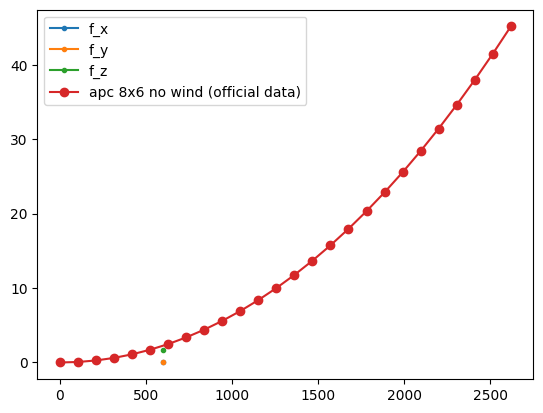

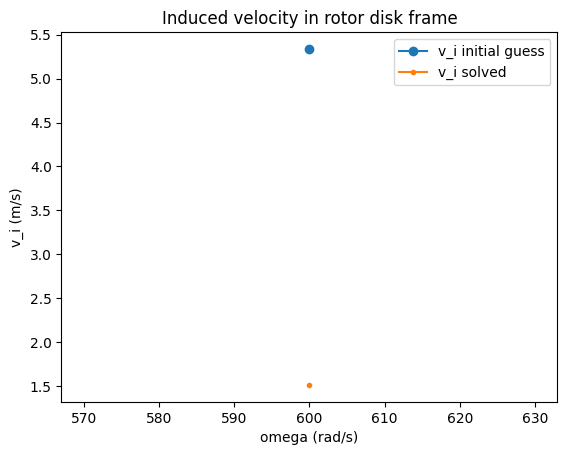

In [4]:
import matplotlib.pyplot as plt
from blade_params import APC_8x6_OfficialData
plt.plot(omega_range, f[0, :], '.-', label='f_x')
plt.plot(omega_range, f[1, :], '.-', label='f_y')
plt.plot(omega_range, f[2, :], '.-', label='f_z')

plt.plot(APC_8x6_OfficialData.get_omega_range(), 
            APC_8x6_OfficialData.get_thrust_range(), 
            'o-', label='apc 8x6 no wind (official data)')
plt.legend()
print(f"f_x: {f[0, :]}")
print(f"f_y: {f[1, :]}")
print(f"f_z: {f[2, :]}")

plt.figure()
plt.plot(omega_range, v_trail_init, 'o-', label='v_i initial guess')
plt.plot(omega_range, v_trail, '.-', label='v_i solved')
plt.legend()
plt.xlabel('omega (rad/s)')
plt.ylabel('v_i (m/s)')
plt.title('Induced velocity in rotor disk frame')
plt.show()